# Imports

In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
import sys; import os
sys.path.append("..")

from utils import data_pipeline

from IPython.display import display
import pandas as pd
import numpy as np
pd.set_option("display.max_colwidth", None)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() #; sns.set(style="dark"); sns.set_palette("colorblind")

import itertools
import json

# Get the data

In [115]:
SEASON_2019_FILE_NAME = "full_season.json"

In [116]:
with open(os.path.join("raw_data", SEASON_2019_FILE_NAME), "r") as f:
    data = json.load(f)
    data = list(itertools.chain.from_iterable(data))

##### Threshold 15mins, 25percentile

In [136]:
# min_mins_played prunes all rows with under 14 mins played in that game
# n_games_played prunes all rows played by players that have less than 15 entries played in dataset
df = data_pipeline.stats_endpoint_data_pipeline(data=data, min_mins_played=14, min_games_played=None)

### Team related indicators: Home/Away

In [8]:
#df['game_object']

In [9]:
df['home_team_id'] = df["game_object"].apply(lambda d: d['home_team_id'])
df['visitor_team_id'] = df["game_object"].apply(lambda d: d['visitor_team_id'])

In [10]:
cols_to_keep = [ 'own_team_id', 'own_team_name',
        'game_id', 'game_winning_team',
       'home_team_id', 'visitor_team_id']

In [11]:
df_team_eval = df[cols_to_keep]

In [12]:
df_team_eval = df_team_eval.drop_duplicates(subset=['own_team_name', 'game_id'])

In [13]:
df_team_eval['played_home'] = (df_team_eval['own_team_id'] == df_team_eval['home_team_id'])*1
df_team_eval['played_away'] = (df_team_eval['own_team_id'] == df_team_eval['visitor_team_id'])*1
df_team_eval['own_team_won'] = (df_team_eval['own_team_id'] == df_team_eval['game_winning_team'])*1

#### Investigating certain players because performance score too high

In [14]:
df_ctk = ['assists', 'blocks', 'defensive_rebounds',
       'three_pt_attempts', 'three_pt_made',
       'two_pt_attempts', 'two_pt_made',
       'one_pt_attempts', 'one_pt_made',
       'offensive_rebounds', 'personal_fouls', 'points', 'rebounds', 'steals',
       'turnovers', 'own_team_name', 'player_id',
       'player_position', 'player_name','mins_played',
        'performance_score','own_team_won']

In [15]:
df[df_ctk].where(df['player_name']=='Mo Bamba').dropna().T
#df.where(df['player_name']=='Jonathan Isaac').dropna()

id,1730859,1735287,1764423,1797627,1806777,1812083,1823880,1556145,1843565,1869796,...,1616743,1625534,1636578,1649929,1662878,1667557,1676048,1702253,1712816,1722339
assists,3,0,1,1,0,1,0,0,1,1,...,1,2,0,0,0,0,0,0,1,1
blocks,1,1,4,1,1,2,1,0,2,1,...,3,2,2,1,0,4,1,1,0,0
defensive_rebounds,5,3,1,6,9,3,4,2,4,6,...,8,4,3,2,8,8,5,3,3,3
three_pt_attempts,1,4,1,3,2,1,2,1,0,1,...,1,5,1,3,1,2,3,4,1,3
three_pt_made,0,1,0,1,0,1,0,0,0,0,...,0,5,1,0,0,2,1,1,1,2
two_pt_attempts,5,9,3,6,5,3,4,1,1,6,...,8,6,6,7,4,4,5,9,6,6
two_pt_made,2,4,2,3,2,2,2,0,0,2,...,3,5,4,2,2,4,1,5,3,5
one_pt_attempts,0,0,0,0,1,0,2,0,0,2,...,0,0,2,0,0,0,2,2,2,1
one_pt_made,0,0,0,0,1,0,1,0,0,1,...,0,0,2,0,0,0,1,2,2,1
offensive_rebounds,2,2,1,0,2,2,1,0,0,5,...,4,0,4,1,0,3,1,1,3,3


### Home/ Away games winratios

In [16]:
# df_home_games = (df_team_eval.where(df_team_eval['played_home']==1).dropna())
# df_away_games = (df_team_eval.where(df_team_eval['played_away']==1).dropna())

# home_standings = df_home_games.groupby('own_team_name').sum()
# home_standings['winratio_at_home'] = round((home_standings['own_team_won']) / (home_standings['played_home']),2)

# away_standings = df_away_games.groupby('own_team_name').sum()
# away_standings['winratio_away'] = round((away_standings['own_team_won']) / (away_standings['played_away']),2)

# ctk_1 = ['own_team_id','winratio_at_home']
# ctk_2 = ['own_team_id','winratio_away']

# home_standings = home_standings[ctk_1]
# away_standings = away_standings[ctk_2]

# winratios = [home_standings['winratio_at_home'],away_standings['winratio_away']]
# winratios = pd.DataFrame(winratios)
# winratios = winratios.T

In [17]:
df_winratios = df_team_eval.groupby(['own_team_name','played_home', 'played_away'],as_index=False).agg({'own_team_won': 'mean'})

df_winratios_home = df_winratios.where(df_winratios['played_home'] == 1).dropna()
df_winratios_away = df_winratios.where(df_winratios['played_home'] == 0).dropna()

df_winratios = pd.merge(df_winratios_home,df_winratios_away,on='own_team_name', how='outer')
df_winratios = df_winratios.rename(columns={'own_team_won_x': 'winrate_home','own_team_won_y': 'winrate_away'})

In [18]:
df_winratios = df_winratios.rename(columns={'own_team_won_x': 'winrate_home','own_team_won_y': 'winrate_away'})

In [19]:
df_winratios

,own_team_name,played_home_x,played_away_x,winrate_home,played_home_y,played_away_y,winrate_away
0,Atlanta Hawks,1.0,0.0,0.424242,0.0,1.0,0.187500
1,Boston Celtics,1.0,0.0,0.718750,0.0,1.0,0.645161
2,Brooklyn Nets,1.0,0.0,0.580645,0.0,1.0,0.387097
3,Charlotte Hornets,1.0,0.0,0.322581,0.0,1.0,0.406250
4,Chicago Bulls,1.0,0.0,0.411765,0.0,1.0,0.258065
5,Cleveland Cavaliers,1.0,0.0,0.305556,0.0,1.0,0.285714
6,Dallas Mavericks,1.0,0.0,0.575758,0.0,1.0,0.625000
7,Denver Nuggets,1.0,0.0,0.781250,0.0,1.0,0.548387
8,Detroit Pistons,1.0,0.0,0.312500,0.0,1.0,0.250000
9,Golden State Warriors,1.0,0.0,0.235294,0.0,1.0,0.206897


### Games played (David)

In [20]:
df_games_played = pd.DataFrame(data=df['player_name'].value_counts())
df_games_played = df_games_played.reset_index()
df_games_played.columns = ['player_name', 'games_played'] # change column names

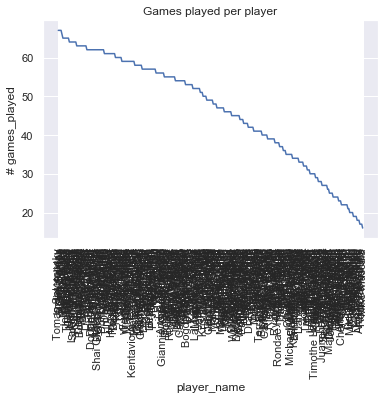

In [21]:
plt.figure()
plt.plot(df_games_played['player_name'], df_games_played['games_played'])
plt.xlabel('player_name')
plt.ylabel("# games_played")
plt.title("Games played per player")
plt.xticks(rotation=90)
plt.show();

In [22]:
df_games_played.describe()

,games_played
count,331.000000
mean,46.410876
std,13.910550
min,16.000000
25%,35.000000
50%,49.000000
75%,58.500000
max,67.000000


##### Threshold 14 games, 25percentile

In [23]:
df2 = df.merge(df_games_played, left_on='player_name', right_on='player_name')
df3 = df2.loc[df2['games_played'] > 13]
print(len(df2),len(df3))
print(len(df3)/len(df2))

15362 15362
1.0


In [24]:
df = df3.copy()
del df2; del df3

In [25]:
df

,assists,blocks,defensive_rebounds,three_pt_percentage,three_pt_attempts,three_pt_made,two_pt_percentage,two_pt_attempts,two_pt_made,one_pt_percentage,...,game_id,mins_played,secs_played,performance_score,game_winning_team,own_team_won,team_points_share,home_team_id,visitor_team_id,games_played
0,8,1,8,20.0,5,1,36.8,19,7,75.0,...,62585,36.0,0.0,39.914330,13,False,0.176471,13,14,59
1,9,0,8,0.0,6,0,40.0,20,8,50.0,...,62985,34.0,54.0,39.784030,12,False,0.196078,12,14,59
2,11,0,12,42.9,7,3,42.1,19,8,100.0,...,63000,36.0,44.0,50.710594,17,False,0.201923,17,14,59
3,11,1,10,33.3,6,2,52.6,19,10,88.9,...,62683,35.0,11.0,69.875776,14,True,0.254237,5,14,59
4,10,1,6,16.7,12,2,37.5,24,9,75.0,...,63041,38.0,49.0,54.268736,13,False,0.216981,14,13,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15357,1,0,9,0.0,4,0,33.3,6,2,50.0,...,62899,25.0,57.0,37.931034,30,True,0.042017,30,23,28
15358,1,0,7,25.0,4,1,50.0,14,7,100.0,...,62907,30.0,35.0,45.348837,16,False,0.184466,16,30,28
15359,0,0,5,100.0,2,2,66.7,3,2,50.0,...,62922,17.0,34.0,27.211672,13,False,0.058824,30,13,28
15360,3,1,3,0.0,2,0,42.9,7,3,100.0,...,62935,25.0,44.0,37.104072,4,False,0.084112,4,30,28


# Analysis

## Performance score distribution

In [26]:
PERF_GRADING_NUMERIC_COLS = data_pipeline.PERF_GRADING_NUMERIC_COLS
# ["assists", "blocks", "rebounds", "points", "steals", "turnovers", "personal_fouls","one_pt_attempts","two_pt_attempts","three_pt_attempts"]

In [27]:
df['three_pt_attempts'].unique()

array([ 5,  6,  7, 12,  4,  3,  9,  2,  8, 10, 11,  0,  1, 13, 20, 15, 14,
       16, 17, 21, 19, 22, 18], dtype=int64)

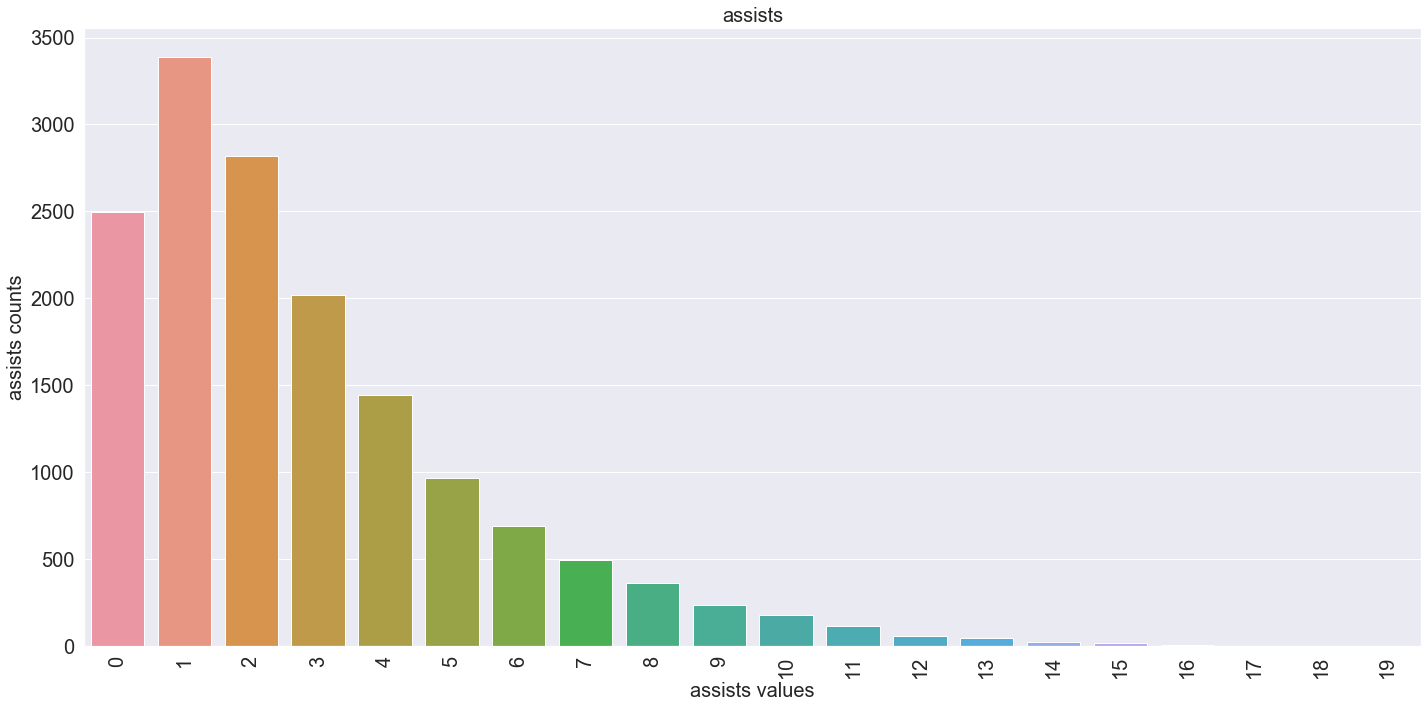

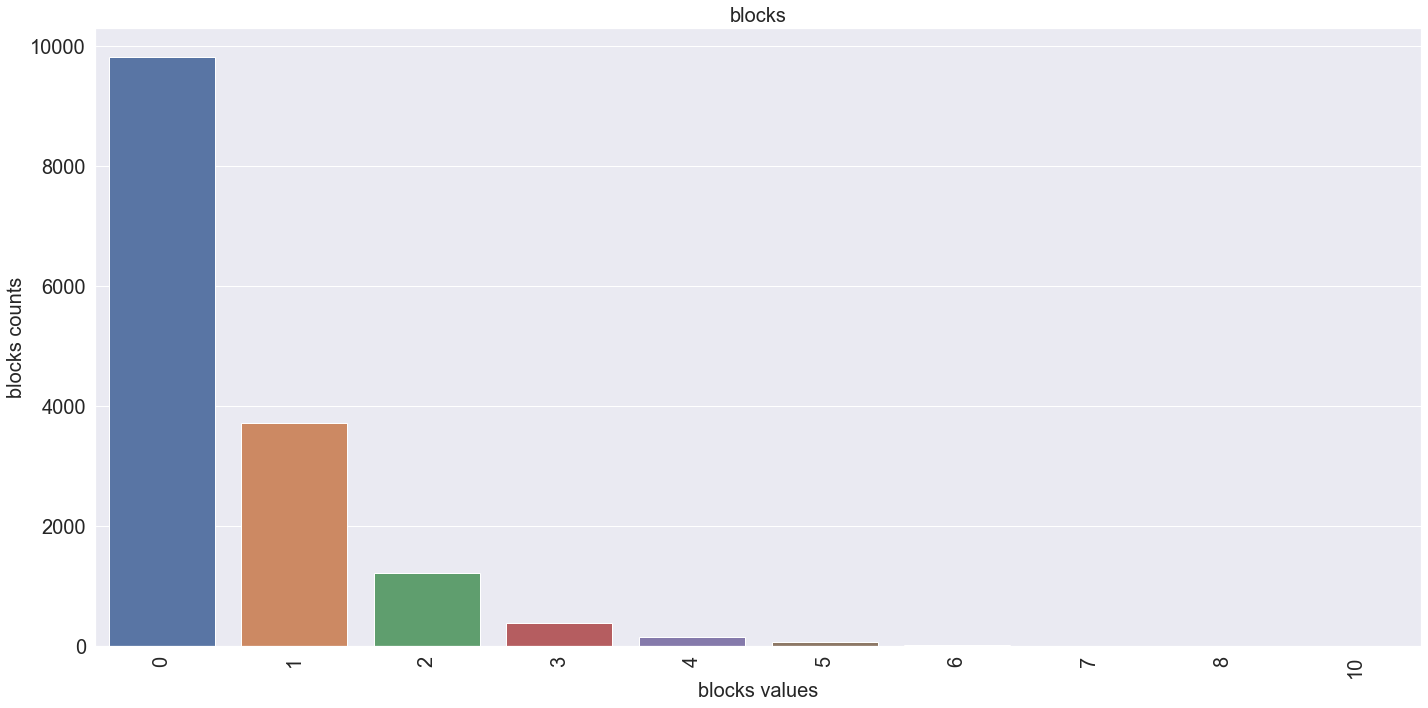

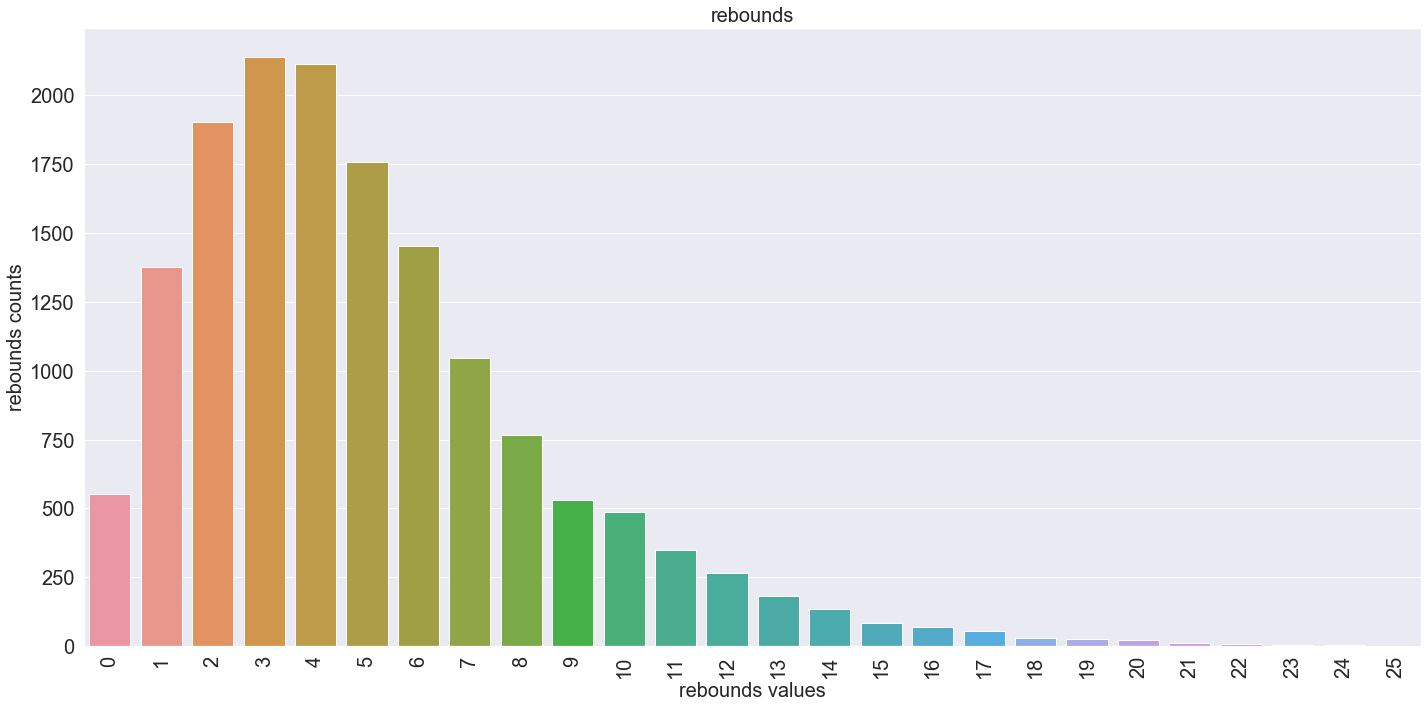

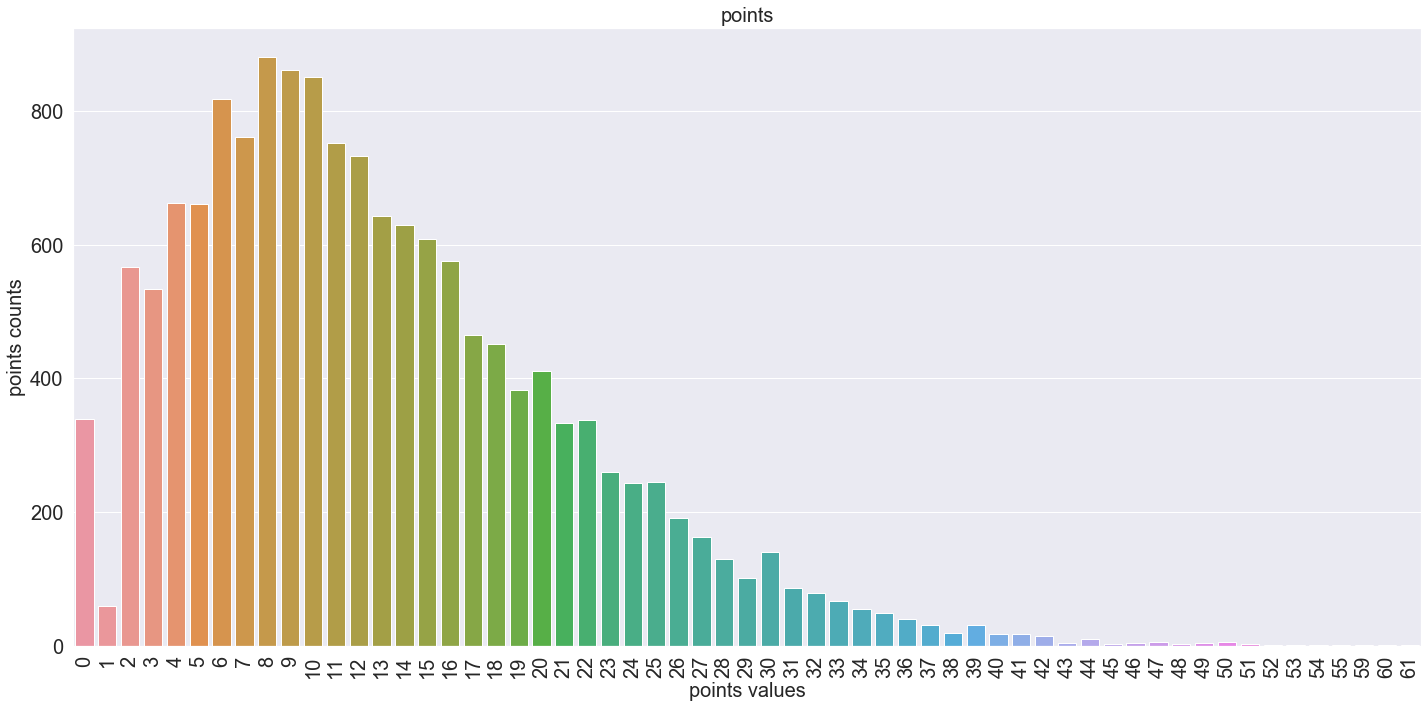

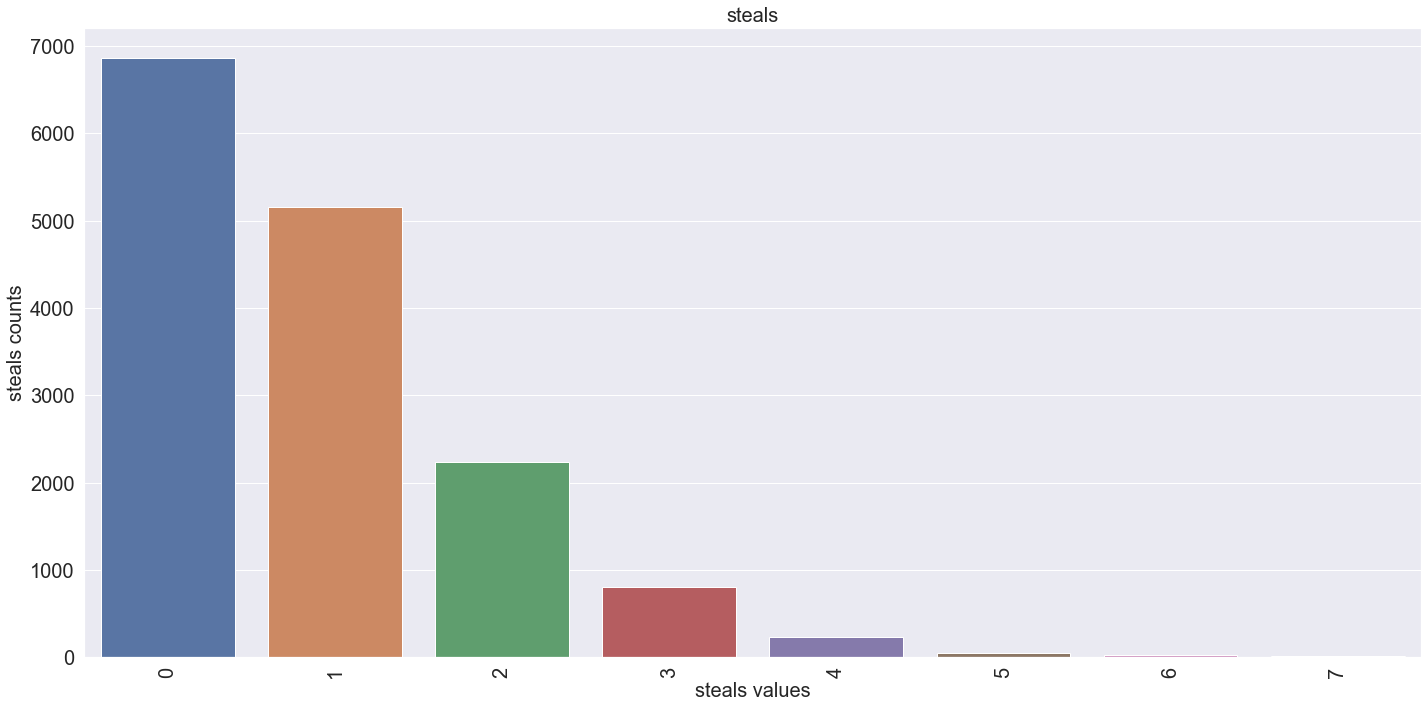

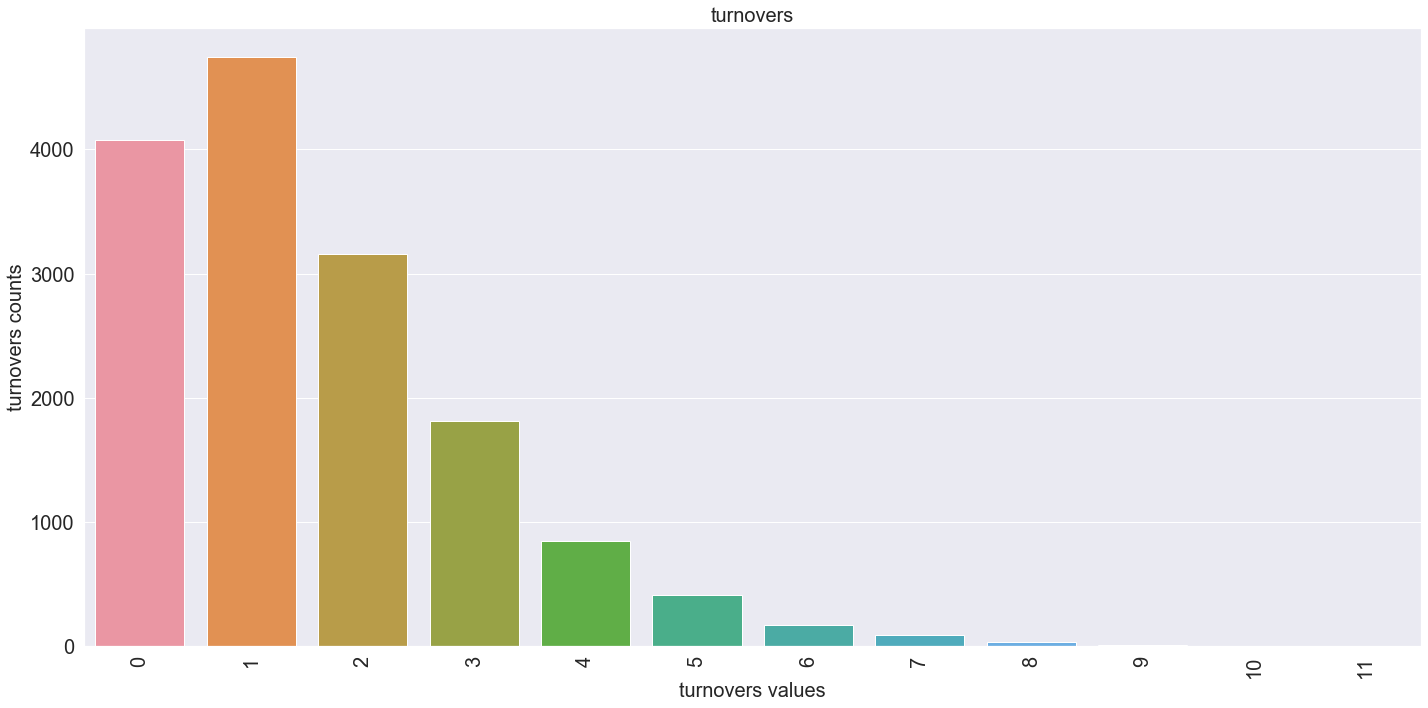

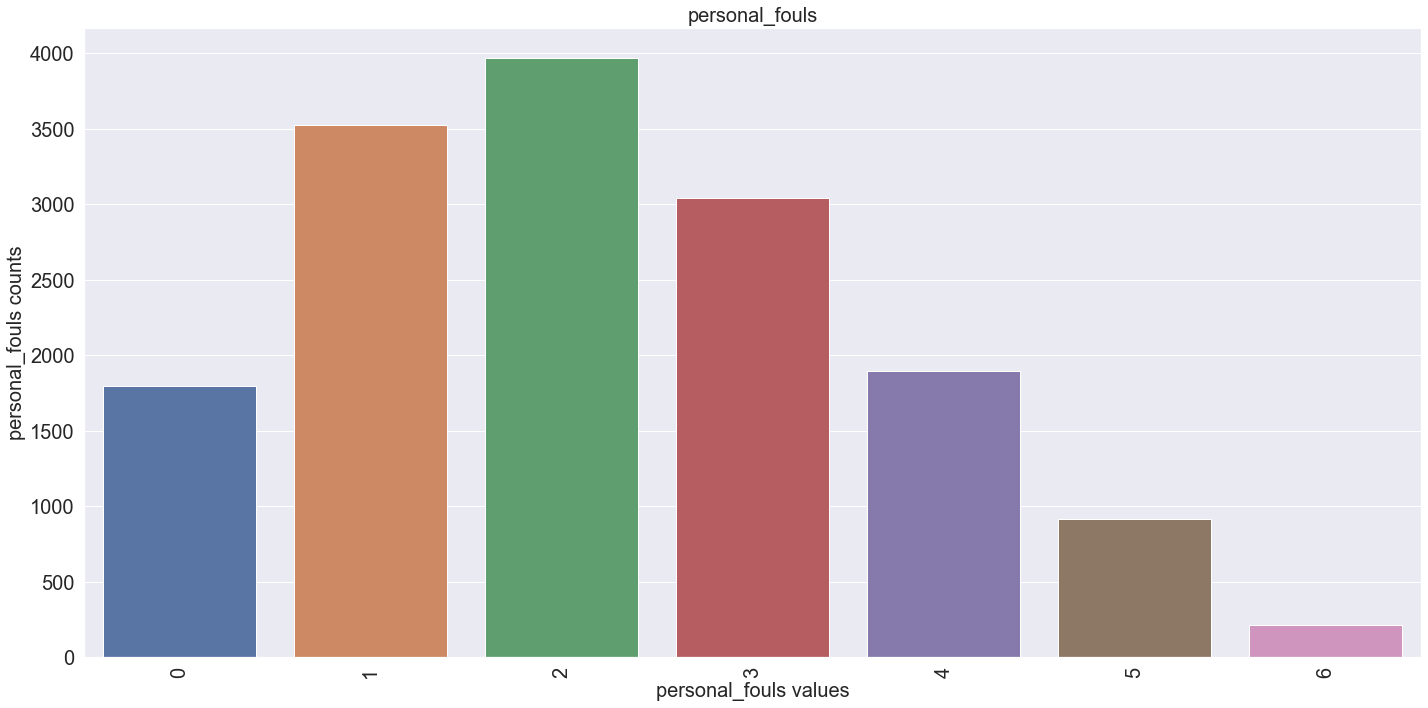

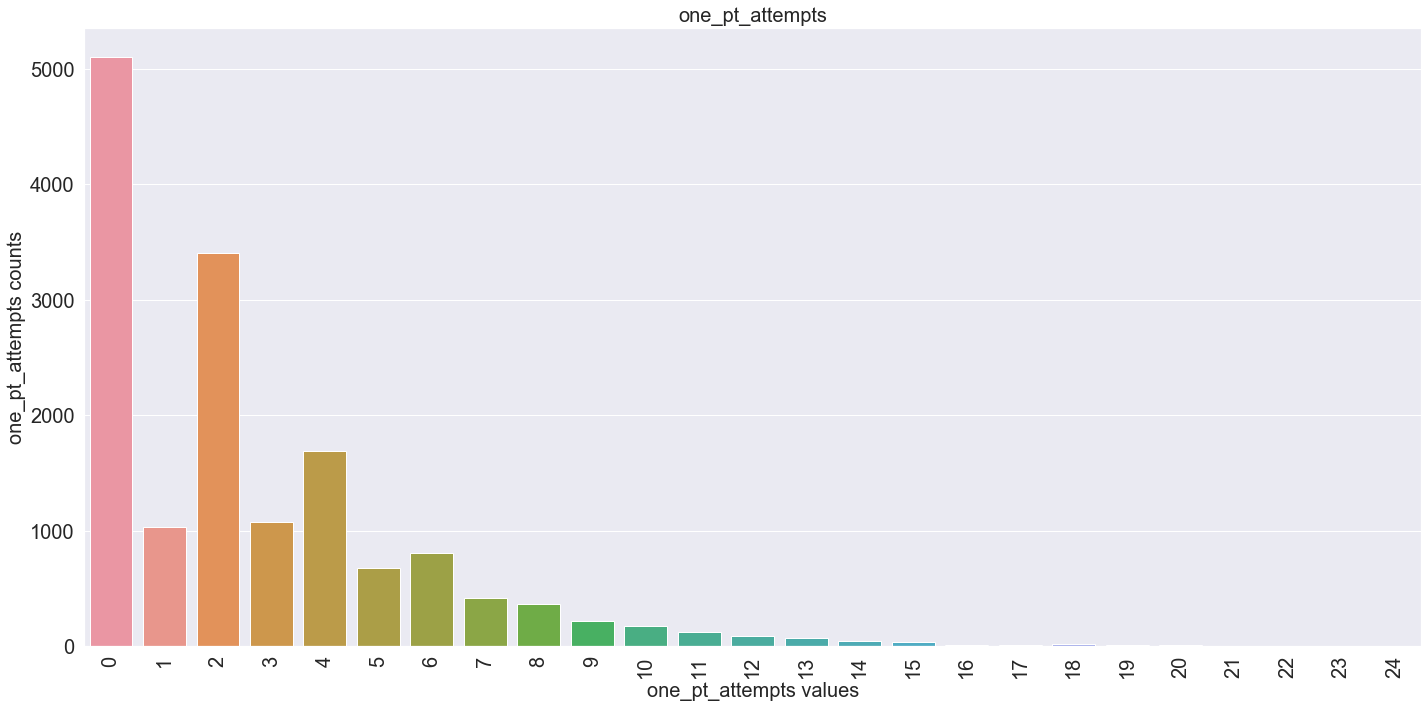

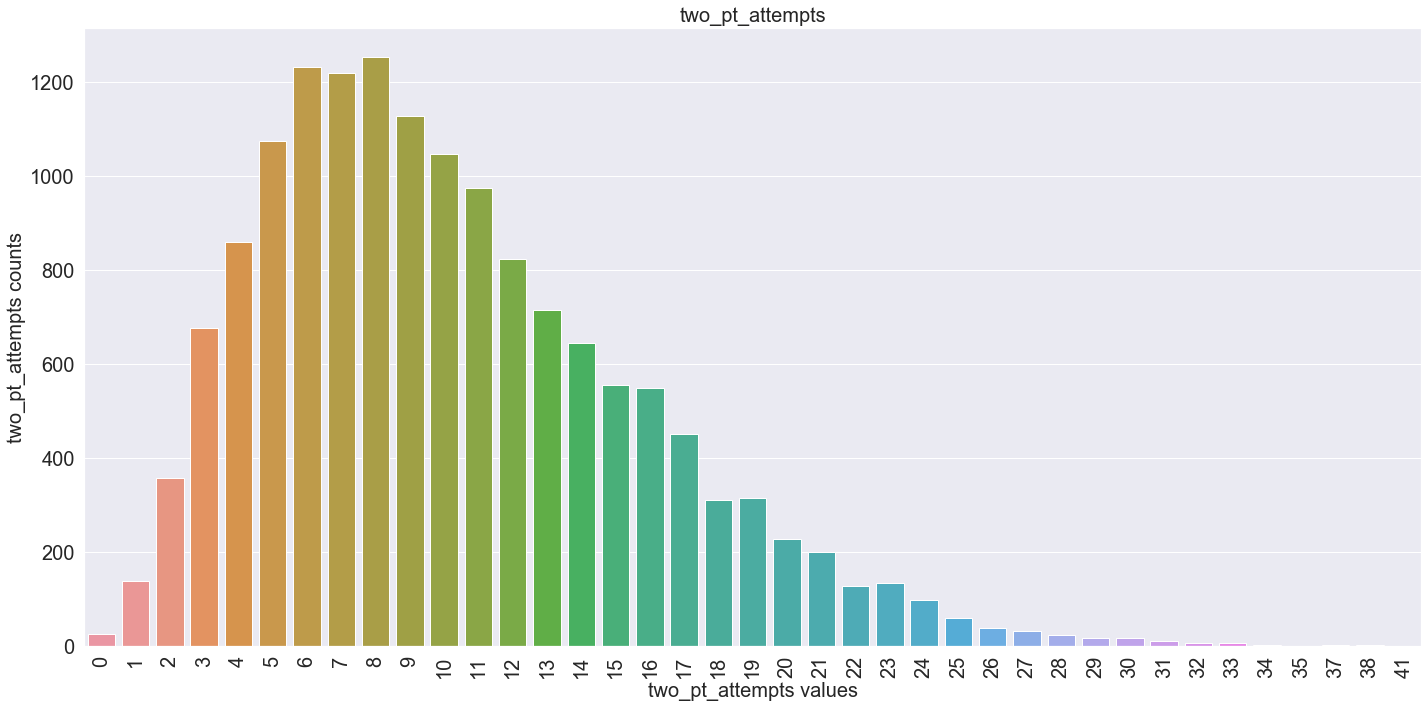

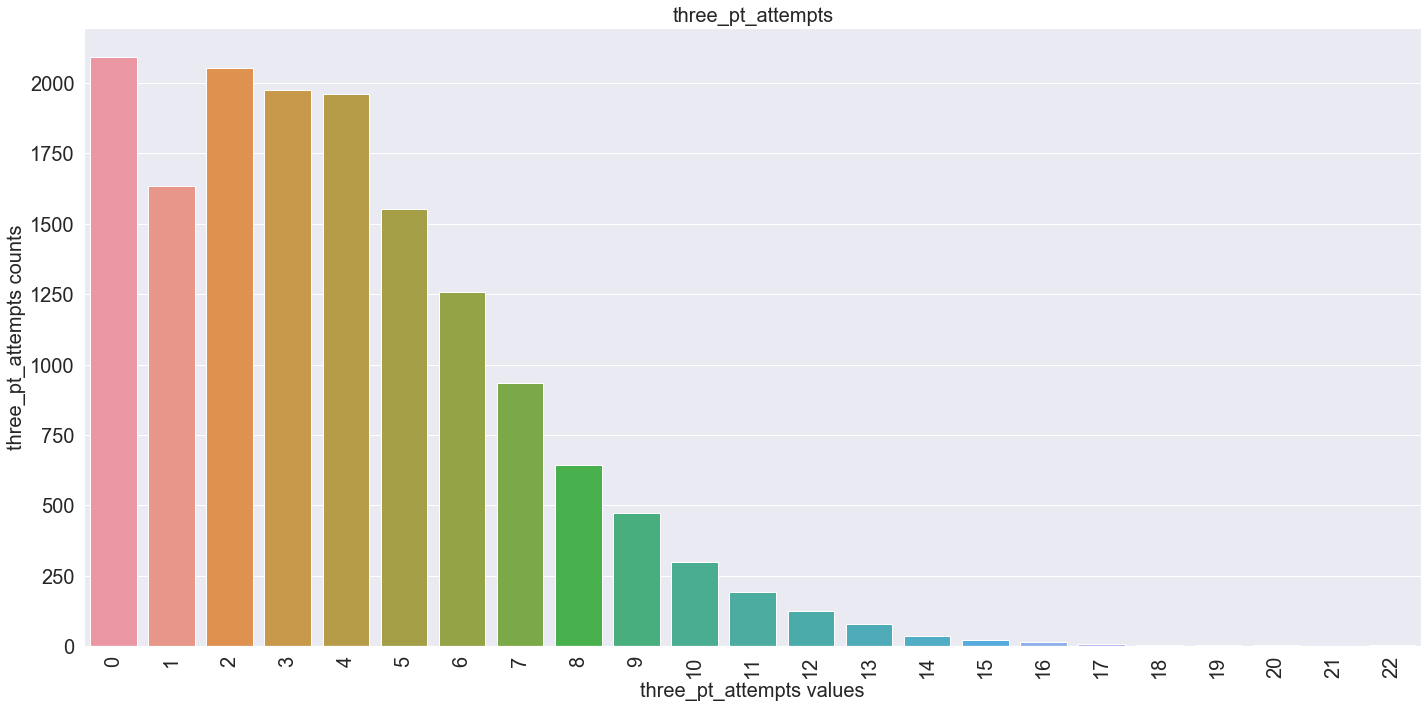

In [28]:
# plt.rc("font", size=20)
plt.rc("axes", labelsize=20)
plt.rc("axes", titlesize=20)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

for col in PERF_GRADING_NUMERIC_COLS:
    fig, ax = plt.subplots(figsize=(20, 10))
    ax = sns.countplot(data=df, x=col, ax=ax)
#     ax = df[col].value_counts().plot.bar(order=df[col].value_counts().index)
    ax.set(xlabel=f"{col} values", ylabel=f"{col} counts", title=col)
    plt.xticks(rotation=90)
    plt.tight_layout();
    plt.show();

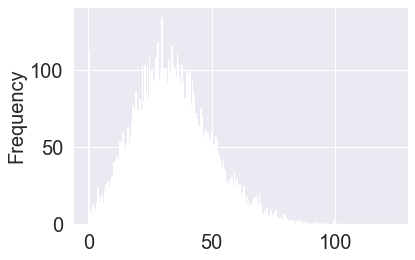

In [29]:
df.performance_score.plot.hist(bins=500);

## Analyzing any particular team

In [30]:
def analyze_team(team_name: str, **kwargs) -> None:
    team_df = df.loc[df.own_team_name == team_name]
    if team_df.empty:
        return
    return team_df.groupby("player_name").agg({"performance_score": ["mean", "std"]})\
        .sort_values(by=("performance_score", "mean")).plot.bar(title=team_name);

C:\Users\Jonas\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


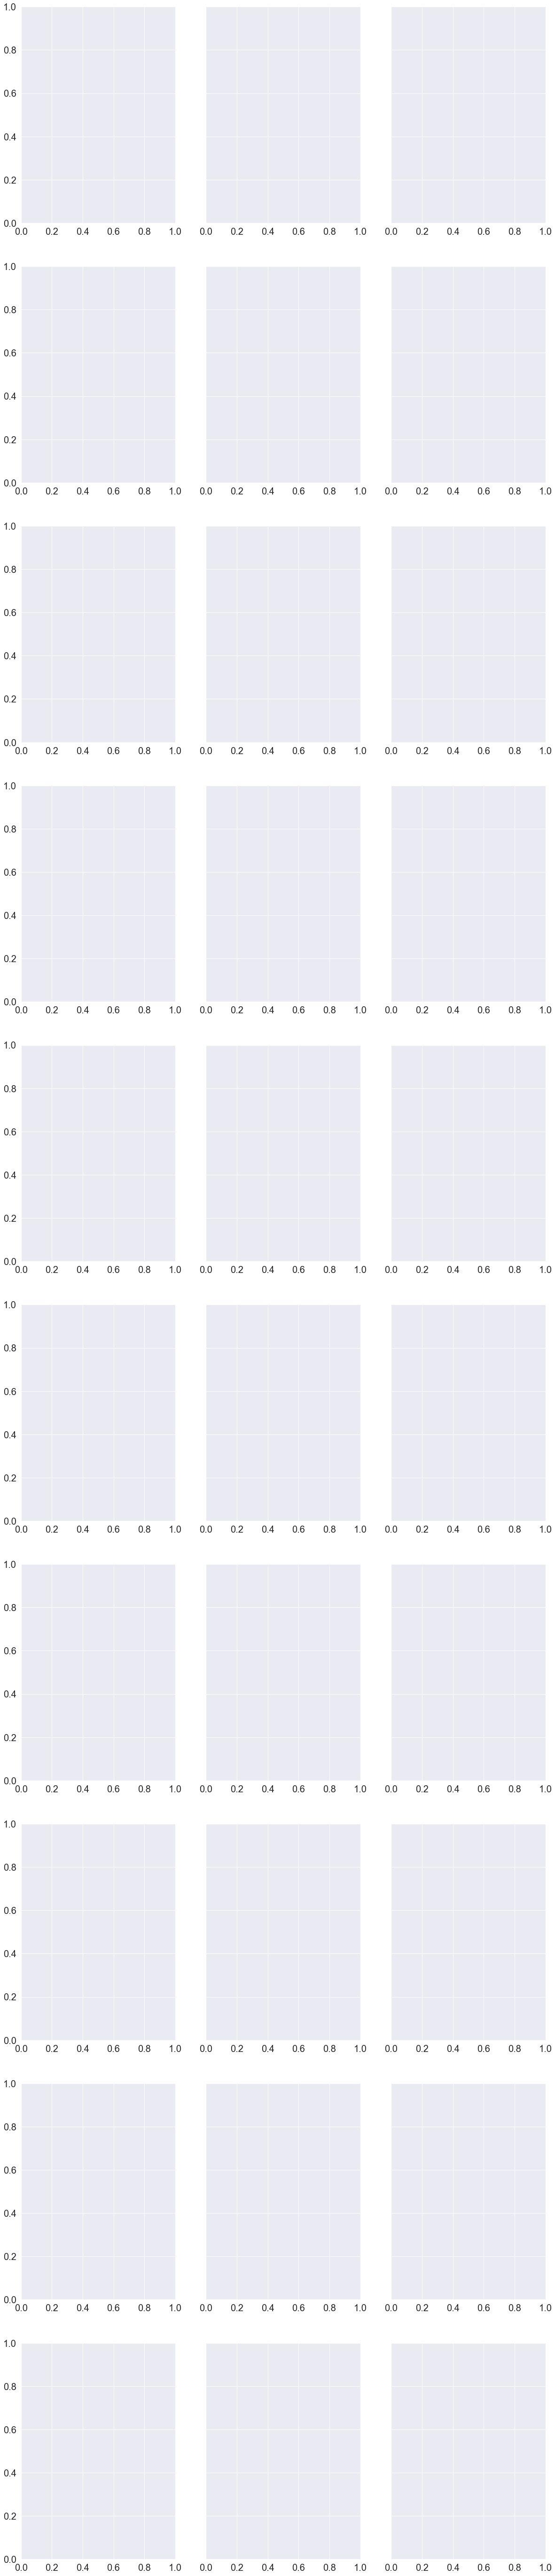

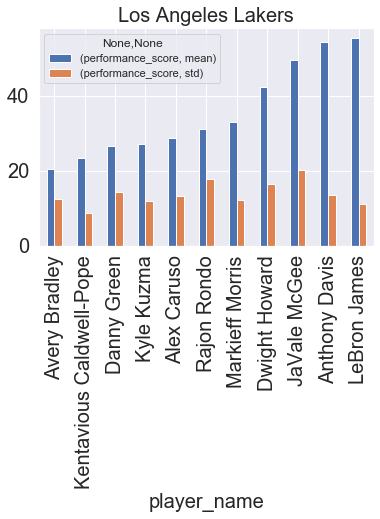

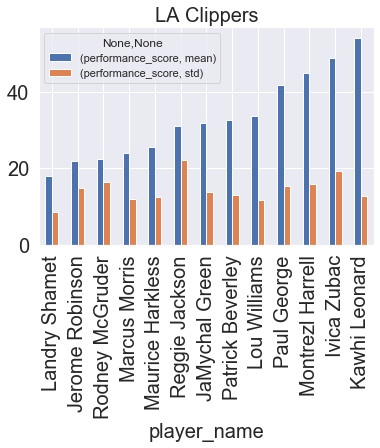

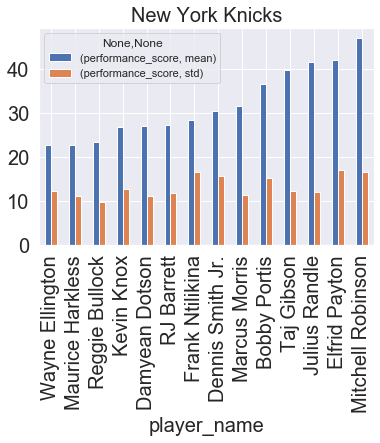

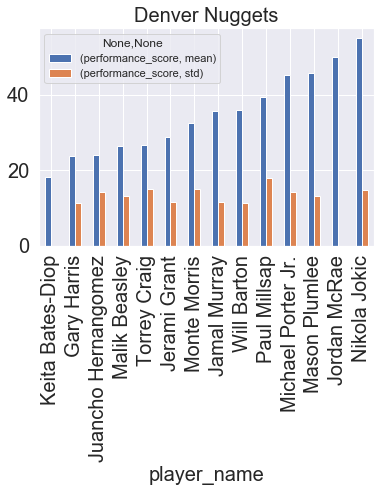

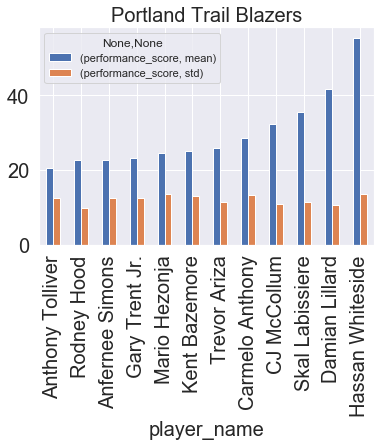

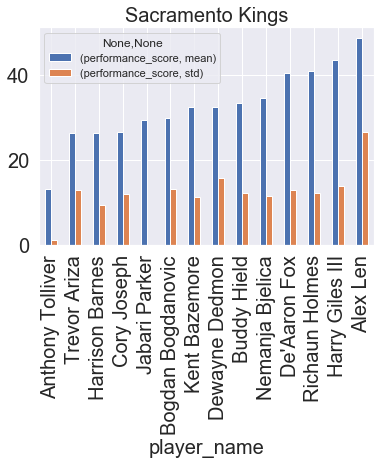

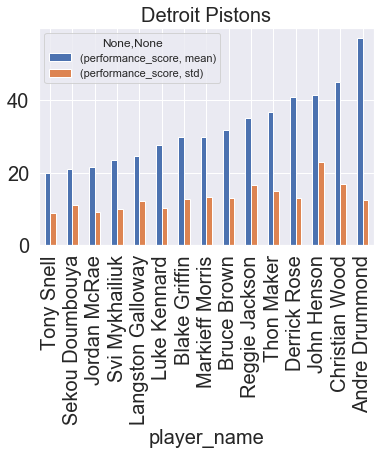

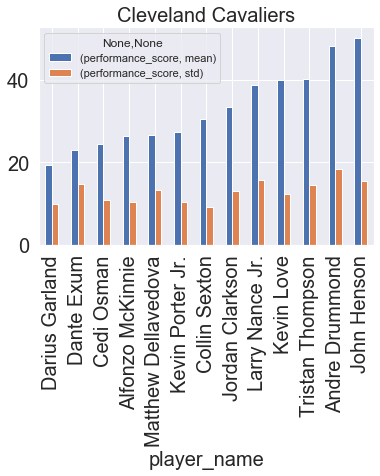

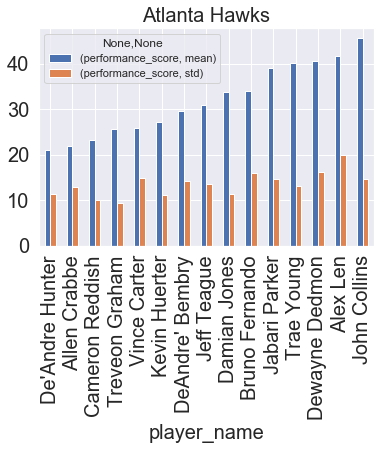

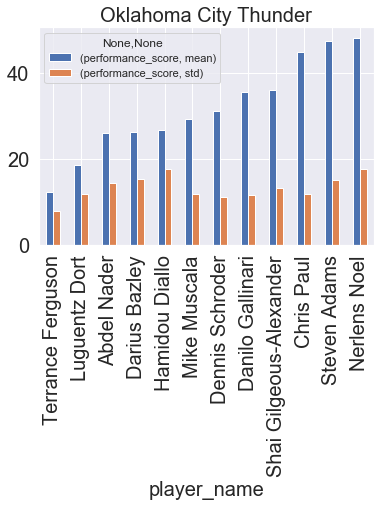

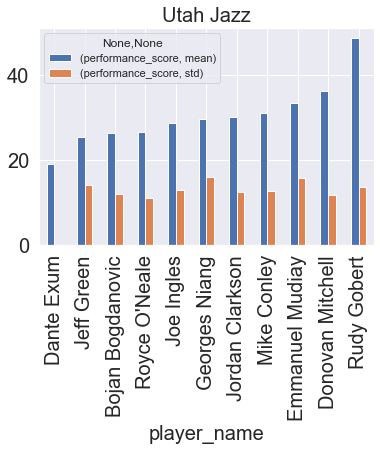

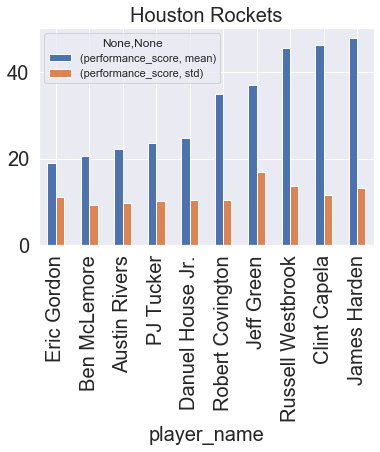

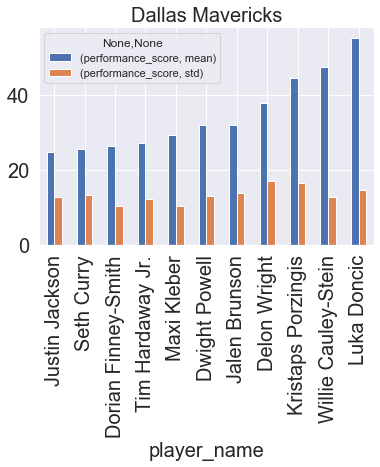

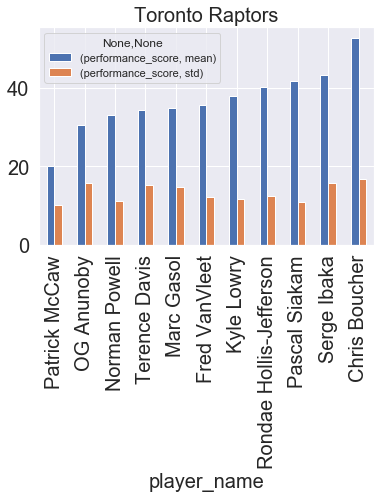

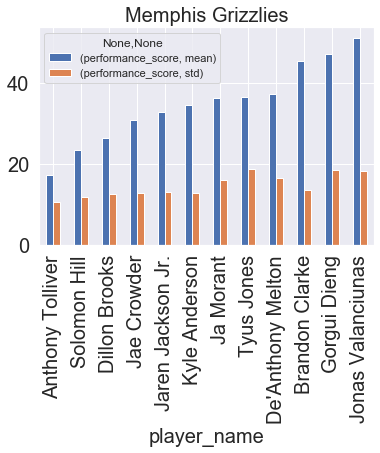

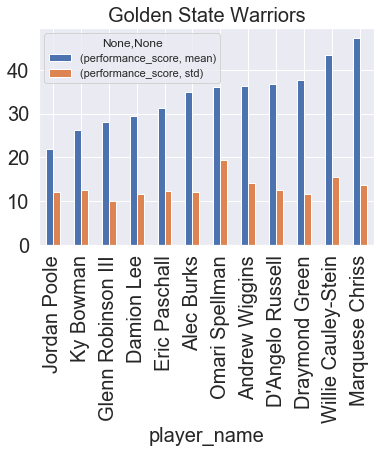

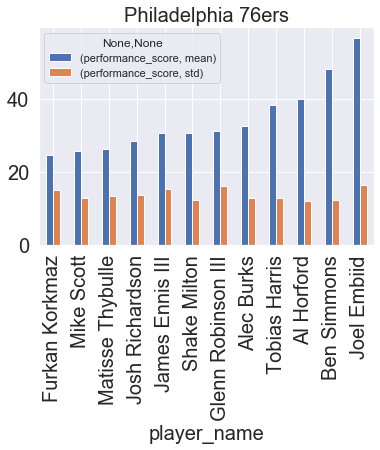

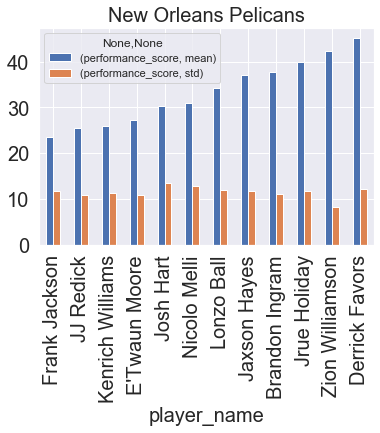

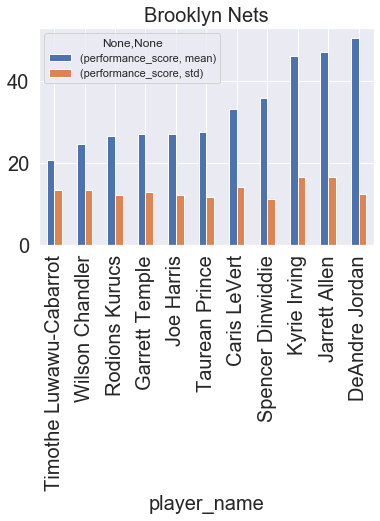

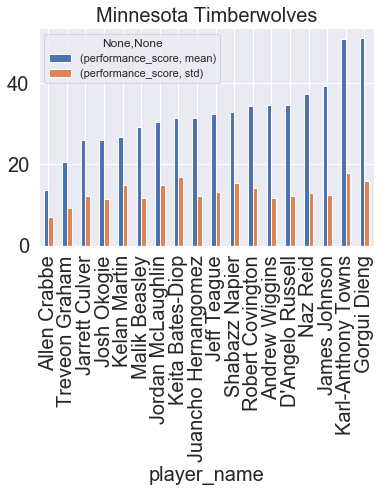

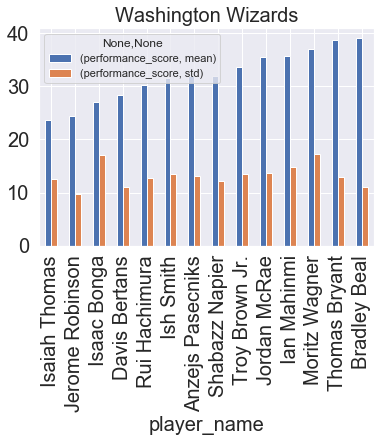

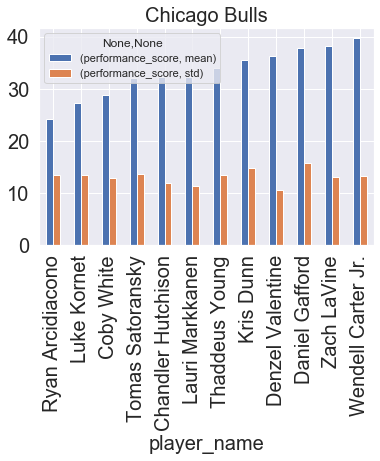

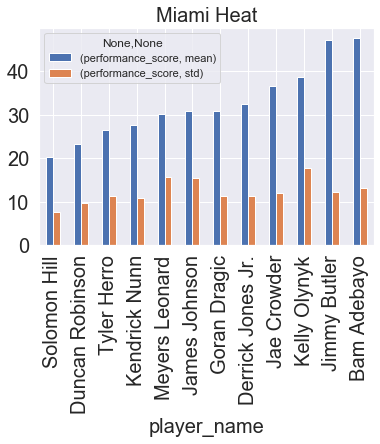

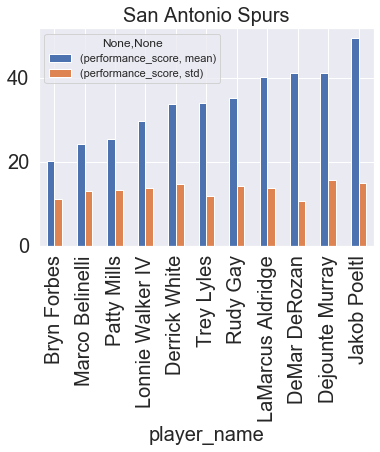

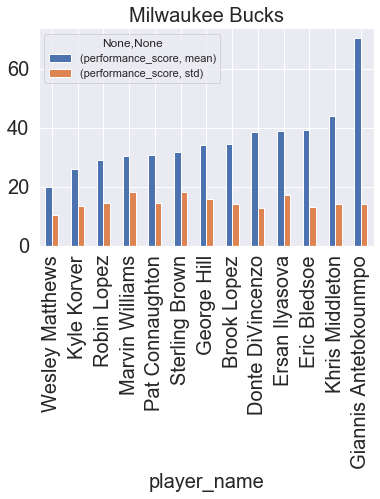

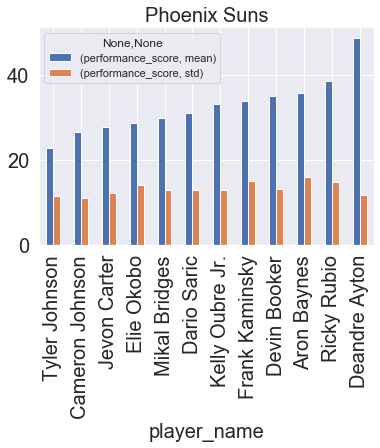

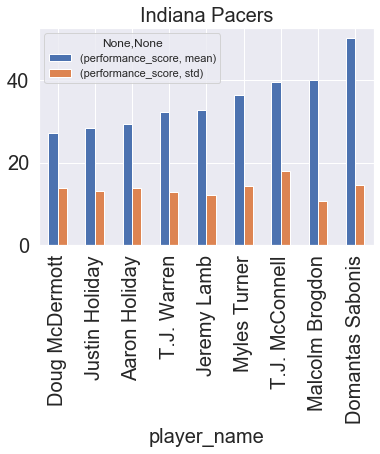

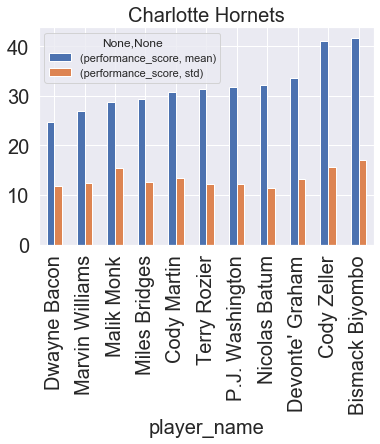

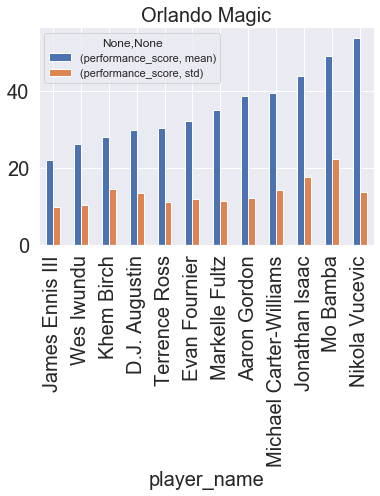

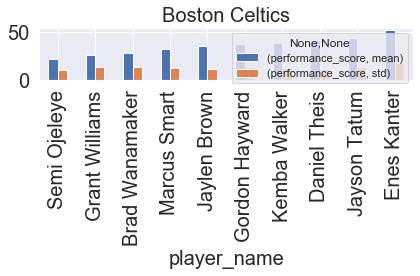

In [31]:
# analyze_team("Milwaukee Bucks")
team_names = list(df.own_team_name.unique())
fig, ax = plt.subplots(nrows=len(team_names) // 3 + len(team_names) % 3, ncols=3, sharey=True)
fig.set_figheight(100); fig.set_figwidth(20)
for idx, team in enumerate(team_names):
    plot = analyze_team(team, ax=ax, pos=idx)
    x_plot_pos, y_plot_pos = idx // 3, idx % 3
    ax[x_plot_pos, y_plot_pos] = plot

plt.tight_layout()
plt.show();

## Inspecting correlation between performance_score and winning

In [32]:
df_summed = df.groupby(["game_id", "own_team_id", "game_winning_team"])\
    .agg({"performance_score": "mean"})

In [33]:
df_summed.reset_index(inplace=True)
df_summed["is_winning_team"] = df_summed\
    .apply(lambda x: x['own_team_id'] == x["game_winning_team"], axis=1)
df_summed["has_highest_score"] = df_summed\
    .apply(lambda s: s["performance_score"] == df_summed.groupby("game_id")\
               .agg({"performance_score": "max"}).loc[s.game_id], axis=1)

df_summed["highest_score_did_win"] = df_summed.apply(lambda s: s.is_winning_team == s.has_highest_score, axis=1)
df["home_team_did_win"] = df.apply(lambda s: s["game_winning_team"] == s["game_object"].get("home_team_id"), axis=1)

#### ?????

In [34]:
dcols = ['own_team_name','performance_score','game_winning_team','own_team_id']
df[dcols].head(20)

,own_team_name,performance_score,game_winning_team,own_team_id
0,Los Angeles Lakers,39.914330,13,14
1,Los Angeles Lakers,39.784030,12,14
2,Los Angeles Lakers,50.710594,17,14
3,Los Angeles Lakers,69.875776,14,14
4,Los Angeles Lakers,54.268736,13,14
5,Los Angeles Lakers,60.763889,14,14
6,Los Angeles Lakers,55.056505,14,14
7,Los Angeles Lakers,67.257989,14,14
8,Los Angeles Lakers,53.825011,14,14
9,Los Angeles Lakers,63.414634,14,14


In [35]:
df_summed.columns

Index(['game_id', 'own_team_id', 'game_winning_team', 'performance_score',
       'is_winning_team', 'has_highest_score', 'highest_score_did_win'],
      dtype='object')

In [36]:
team_winrates_df = df.drop_duplicates(subset=["game_id", "own_team_id"], inplace=False)

In [37]:
team_winrates_df.groupby("own_team_id").agg({"own_team_won": "sum"})

,own_team_won
own_team_id,
1,20.0
2,43.0
3,30.0
4,23.0
5,22.0
6,19.0
7,39.0
8,42.0
9,18.0


In [38]:
# in 81% of all games, the team with the higher avg. performance score
# (across all its players with > mins_played_threshold := 14)
# also wins the game.
df_summed.highest_score_did_win.value_counts() / (df_summed.highest_score_did_win.value_counts().sum())

True     0.822034
False    0.177966
Name: highest_score_did_win, dtype: float64

In [39]:
df.groupby(["game_id", "own_team_id", "game_winning_team"])\
    .agg({"performance_score": ["sum", "mean", "max", "count"]})[:50]

performance_score             \
                                                    sum       mean   
game_id own_team_id game_winning_team                                
62585   13          13                       258.101246  36.871607   
        14          13                       219.499929  31.357133   
62586   4           4                        233.861581  29.232698   
        5           4                        253.020273  36.145753   
62588   6           22                       311.273120  34.585902   
        22          22                       326.883750  40.860469   
62592   7           7                        280.128665  31.125407   
        30          7                        256.861359  32.107670   
62594   8           8                        347.909955  38.656662   
        25          8                        198.624259  33.104043   
62595   24          24                       387.266639  43.029627   
        26          24                       187.048595  20.783177   
62596   21          29                       267.529695  29.725522   
        29          29                       256.103630  32.012954   
62597   1           1                        320.151308  35.572368   
        9           1                        253.225079  28.136120   
62598   11          17                       228.020551  32.574364   
        17          17                       390.745083  39.074508   
62599   10          13                       157.276383  26.212731   
        13          13                       285.607794  35.700974   
62600   2           2                        271.703724  38.814818   
        28          2                        192.935241  27.562177   
62601   4           18                       250.155100  31.269387   
        18          18                       337.216755  48.173822   
62602   3           3                        232.980407  29.122551   
        20          3                        186.274417  31.045736   
62603   5           5                        305.618517  38.202315   
        15          5                        320.722064  40.090258   
62605   7           7                        287.550936  35.943867   
        19          7                        275.105232  30.567248   
62606   8           8                        254.457894  31.807237   
        24          8                        228.342062  28.542758   
62609   16          16                       245.072822  30.634103   
        17          16                       213.503090  26.687886   
62610   9           23                       258.690707  28.743412   
        23          23                       200.888275  33.481379   
62611   1           1                        275.022348  34.377793   
        22          1                        303.147755  37.893469   
62612   2           2                        288.426685  41.203812   
        20          2                        237.342104  33.906015   
62613   6           6                        288.719208  32.079912   
        12          6                        191.351100  31.891850   
62614   5           28                       258.230898  28.692322   
        28          28                       345.729368  49.389910   
62615   11          11                       214.161804  30.594543   
        19          11                       189.507498  27.072500   
62617   26          29                       185.637313  20.626368   
        29          29                       338.585796  37.620644   
62618   13          24                       239.087437  29.885930   
        24          24                       279.865098  34.983137   

                                                         
                                              max count  
game_id own_team_id game_winning_team                    
62585   13          13                  49.366898     7  
        14          13                  58.046145     7  
62586   4           4                

#### Players avg performance+std 

In [40]:
df.columns

Index(['assists', 'blocks', 'defensive_rebounds', 'three_pt_percentage',
       'three_pt_attempts', 'three_pt_made', 'two_pt_percentage',
       'two_pt_attempts', 'two_pt_made', 'one_pt_percentage',
       'one_pt_attempts', 'one_pt_made', 'game_object', 'min',
       'offensive_rebounds', 'personal_fouls', 'points', 'rebounds', 'steals',
       'turnovers', 'own_team_id', 'own_team_name', 'player_id',
       'player_position', 'player_name', 'game_id', 'mins_played',
       'secs_played', 'performance_score', 'game_winning_team', 'own_team_won',
       'team_points_share', 'home_team_id', 'visitor_team_id', 'games_played',
       'home_team_did_win'],
      dtype='object')

In [41]:
df_eval = df.loc[:,['player_name', 'performance_score','own_team_id', 'own_team_name',]]
df_eval = df_eval.groupby(['own_team_name',"player_name"]).agg({"performance_score": ["mean", "std"]})

In [42]:
df_eval

performance_score           
                                                mean        std
own_team_name      player_name                                 
Atlanta Hawks      Alex Len                41.689893  19.934228
                   Allen Crabbe            21.933182  12.918346
                   Bruno Fernando          34.023709  16.033994
                   Cameron Reddish         23.258536  10.015652
                   Damian Jones            33.657102  11.391554
...                                              ...        ...
Washington Wizards Moritz Wagner           37.100327  17.277462
                   Rui Hachimura           30.241025  12.729766
                   Shabazz Napier          31.981176  12.107469
                   Thomas Bryant           38.814947  13.009664
                   Troy Brown Jr.          33.669249  13.453165

[369 rows x 2 columns]

In [43]:
df_performance_eval = pd.DataFrame(df_eval)
df_performance_eval = df_performance_eval.reset_index()
df_performance_eval.columns = ['own_team_name','player_name', 'avg_performance_score','avg_performance_deviation'] # change column name
#df_performance_eval = df_performance_eval.set_index(['player_name'])
#df_performance_eval.where(df_performance_eval['own_team_name']=='Los Angeles Lakers').dropna()

In [44]:
df_performance_eval.where(df_performance_eval['own_team_name']=='Detroit Pistons').dropna()

,own_team_name,player_name,avg_performance_score,avg_performance_deviation
97,Detroit Pistons,Andre Drummond,57.108120,12.317826
98,Detroit Pistons,Blake Griffin,29.752652,12.565041
99,Detroit Pistons,Bruce Brown,31.831640,12.921816
100,Detroit Pistons,Christian Wood,44.990205,16.929528
101,Detroit Pistons,Derrick Rose,40.802770,12.947122
102,Detroit Pistons,John Henson,41.397386,22.881395
103,Detroit Pistons,Jordan McRae,21.389301,9.128620
104,Detroit Pistons,Langston Galloway,24.470707,12.283488
105,Detroit Pistons,Luke Kennard,27.656213,10.236826
106,Detroit Pistons,Markieff Morris,29.881823,13.194679


In [45]:
team_names = df_performance_eval['own_team_name'].unique()
team_names = list(team_names)

#### Playinh around with how many players should be taken into consideration for team_avg_performance

In [46]:
top_n_performer = 5

team_top_n_performer = []
for team in team_names:
    temp = df_performance_eval.where(df_performance_eval['own_team_name'] == team).dropna().sort_values(by="avg_performance_score")[-top_n_performer:]
    team_top_n_performer.append(temp)
team_top_n_performer = pd.concat(team_top_n_performer)


team_top_n_performer = team_top_n_performer.groupby('own_team_name').agg({'avg_performance_score':'mean','avg_performance_deviation':'mean'})

team_top_n_performer = pd.DataFrame(team_top_n_performer)
team_top_n_performer = team_top_n_performer.reset_index()
team_top_n_performer.columns = ['own_team_name',f'team_top_n_avg_performance_score',f'team_top_n_avg_performance_deviation']

#### Scaling

In [47]:
from sklearn.preprocessing import MinMaxScaler

In [63]:
scaler = MinMaxScaler(feature_range=(0, 100))

scaled_mean_scores = scaler.fit_transform(
    team_top_n_performer.team_top_n_avg_performance_score.values.reshape(-1, 1)
)

# team_top_n_performer.team_top_n_avg_performance_score = scaled_mean_scores

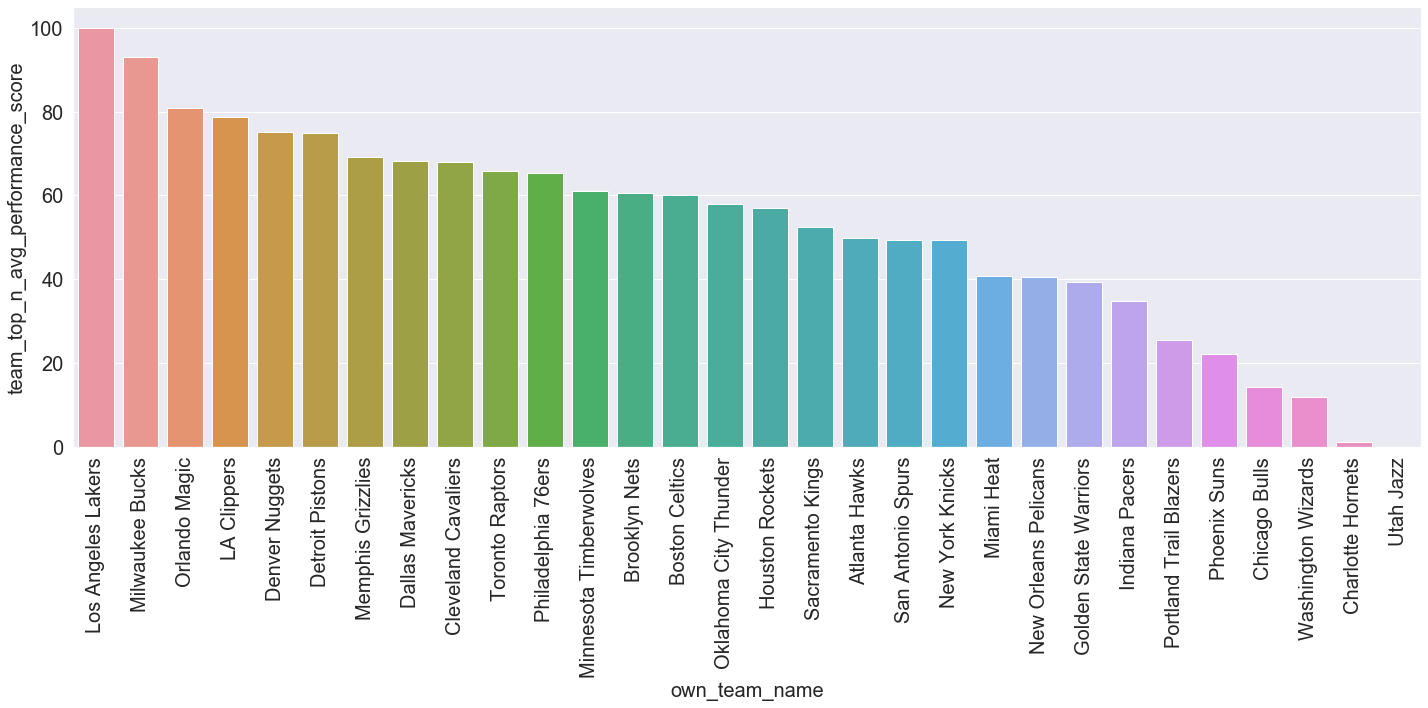

In [65]:
team_top_n_performer.sort_values(by=f"team_top_n_avg_performance_score", ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=team_top_n_performer, x="own_team_name", y=f"team_top_n_avg_performance_score", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout();
plt.show();

In [50]:
df.groupby("player_name").agg({"performance_score": ["mean", "std", "max", "min", "nunique"]}).sort_values(by=("performance_score", "std"), ascending=True)[:30]

performance_score                                   \
                                      mean        std        max        min   
player_name                                                                   
Terrance Ferguson                12.232891   7.738970  31.616983   0.001000   
Zion Williamson                  42.232061   8.314219  62.091503  28.529412   
Landry Shamet                    17.939968   8.637677  40.330513   2.866972   
Tony Snell                       19.830070   8.703661  37.987227   5.858837   
Kentavious Caldwell-Pope         23.364962   8.743702  39.378938   0.001000   
Collin Sexton                    30.397517   9.179976  55.982906  12.771392   
Ben McLemore                     20.716442   9.318723  43.933761   0.001000   
Treveon Graham                   21.908728   9.333348  39.717564   0.001000   
Harrison Barnes                  26.434189   9.425617  46.713039   6.438874   
Duncan Robinson                  23.238599   9.724525  43.163464   0.383142   
Rodney Hood                      22.678141   9.763331  42.259084   5.841121   
Darius Garland                   19.273677   9.807244  39.329685   0.001000   
Austin Rivers                    22.197173   9.871044  48.809524   2.318572   
Reggie Bullock                   23.476031   9.871434  42.582690   3.968254   
Cameron Reddish                  23.258536  10.015652  44.436545   0.001000   
Svi Mykhailiuk                   23.478168  10.053593  42.773752   0.001000   
PJ Tucker                        23.523701  10.150525  49.546094   6.231960   
Patrick McCaw                    20.021799  10.157049  42.233560   6.914894   
Luke Kennard                     27.656213  10.236826  51.586079  10.738832   
Kevin Porter Jr.                 27.232292  10.274209  47.803413   5.580357   
Dorian Finney-Smith              26.407934  10.291287  64.862268   5.843852   
Wesley Matthews                  19.908638  10.406772  50.977944   1.097936   
Alfonzo McKinnie                 26.479522  10.433856  52.408177   8.009612   
Wes Iwundu                       26.083226  10.439799  47.790467   7.240653   
Danuel House Jr.                 24.750275  10.460437  45.828066   2.289377   
Maxi Kleber                      29.400697  10.484033  52.332536   6.645401   
DeMar DeRozan                    41.086251  10.535238  63.607776  22.376543   
Malcolm Brogdon                  40.019477  10.633519  68.445796  15.670387   
Denzel Valentine                 36.271374  10.642199  62.070283  20.138889   
Damian Lillard                   41.746750  10.813445  69.143819  22.379206   

                                  
                         nunique  
player_name                       
Terrance Ferguson             38  
Zion Williamson               19  
Landry Shamet                 43  
Tony Snell                    55  
Kentavious Caldwell-Pope      57  
Collin Sexton                 64  
Ben McLemore                  56  
Treveon Graham                29  
Harrison Barnes               62  
Duncan Robinson               61  
Rodney Hood                   16  
Darius Garland                58  
Austin Rivers                 55  
Reggie Bullock                26  
Cameron Reddish               53  
Svi Mykhailiuk                46  
PJ Tucker                     63  
Patrick McCaw                 34  
Luke Kennard                  26  
Kevin Porter Jr.              45  
Dorian Finney-Smith           61  
Wesley Matthews               59  
Alfonzo McKinnie              23  
Wes Iwundu                    32  
Danuel House Jr.              56  
Maxi Kleber                   61  
DeMar DeRozan                 58  
Malcolm Brogdon               43  
Denzel Valentine              18  
Damian Lillard                55

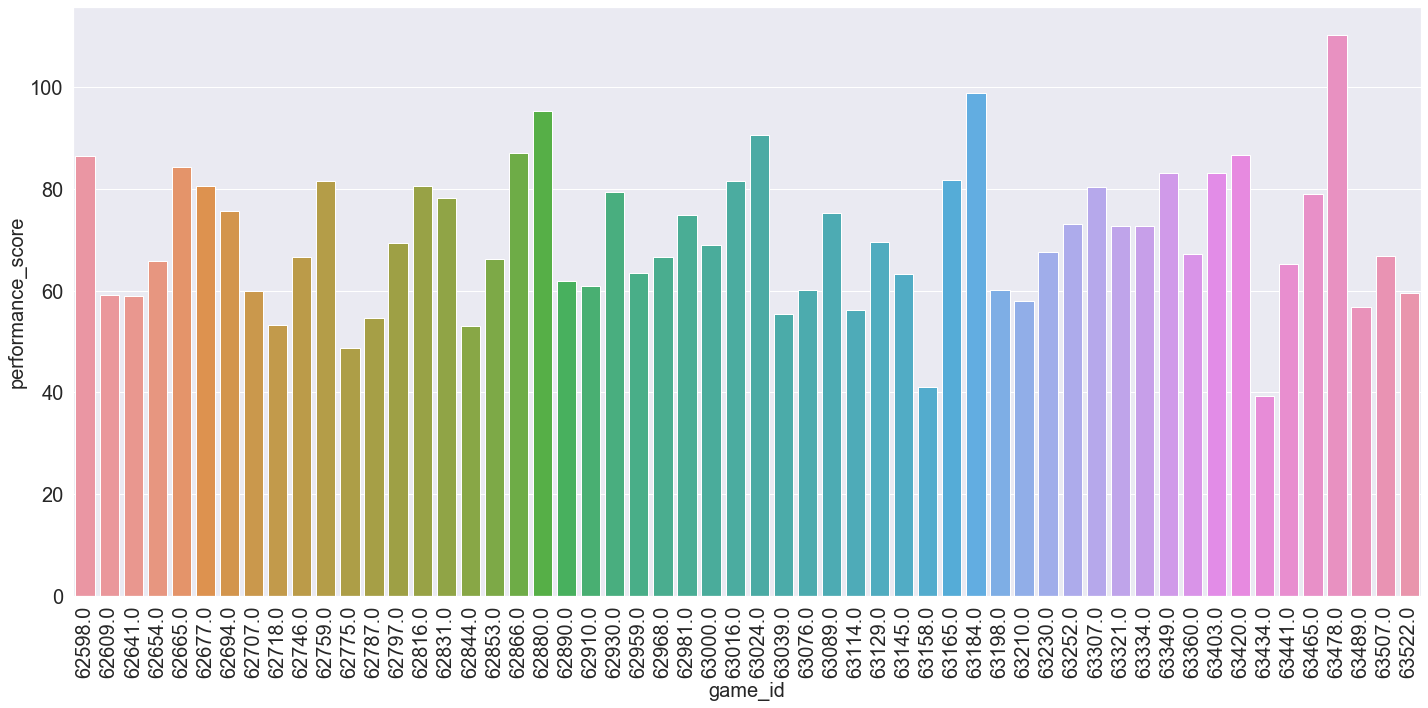

In [51]:
harden = df.loc[df.player_name == "Giannis Antetokounmpo"].copy()
harden.sort_values(by="game_id", inplace=True)
harden.game_id = harden.game_id.astype("float")
harden.performance_score = harden.performance_score.astype("float")

_, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=harden, x="game_id", y="performance_score", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout();
plt.show();

In [52]:
#### Nonsense upcoming

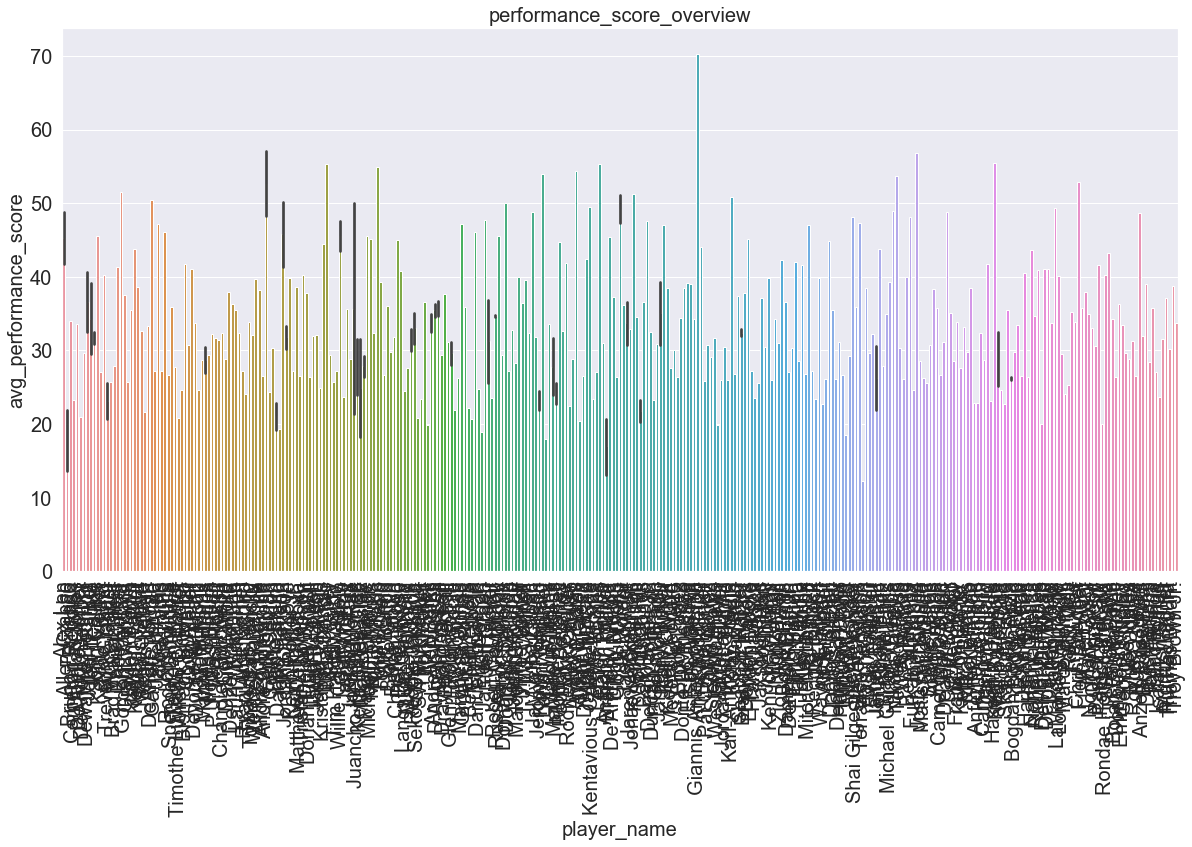

In [53]:
_, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="player_name", y="avg_performance_score", data=df_performance_eval, ax=ax)
# plt.bar(df_performance_eval['player_name'], df_performance_eval['avg_performance_score'])
plt.xlabel('player_name')
plt.ylabel("avg_performance_score")
plt.title("performance_score_overview")
plt.xticks(rotation=90)
plt.show();

In [54]:
df_performance_eval.describe()

,avg_performance_score,avg_performance_deviation
count,369.000000,365.000000
mean,33.358227,13.276631
std,8.951197,2.567860
min,12.232891,1.151040
25%,26.633946,11.698294
50%,32.125092,12.947122
75%,38.814947,14.578977
max,70.292243,26.529105


In [55]:
from sklearn.preprocessing import MinMaxScaler

In [56]:
df_performance_eval.columns

Index(['own_team_name', 'player_name', 'avg_performance_score',
       'avg_performance_deviation'],
      dtype='object')

In [57]:
scaler = MinMaxScaler()
df_performance_eval['scaled_perf'] = (scaler.fit_transform(df_performance_eval['avg_performance_score'].values.reshape(-1,1)))*100
df_performance_eval['scaled_perf']  = round(df_performance_eval['scaled_perf'],2)

df_performance_eval['scaled_std'] = (scaler.fit_transform(df_performance_eval['avg_performance_deviation'].values.reshape(-1,1)))*100
df_performance_eval['scaled_std'] = round(df_performance_eval['scaled_std'],2)

df_performance_eval['scaled_perf']

0      50.74
1      16.71
2      37.53
3      18.99
4      36.90
       ...  
364    42.83
365    31.02
366    34.01
367    45.78
368    36.92
Name: scaled_perf, Length: 369, dtype: float64

In [58]:
df_performance_eval['scaled_std']

0      74.01
1      46.37
2      58.64
3      34.93
4      40.35
       ...  
364    63.54
365    45.62
366    43.17
367    46.73
368    48.48
Name: scaled_std, Length: 369, dtype: float64

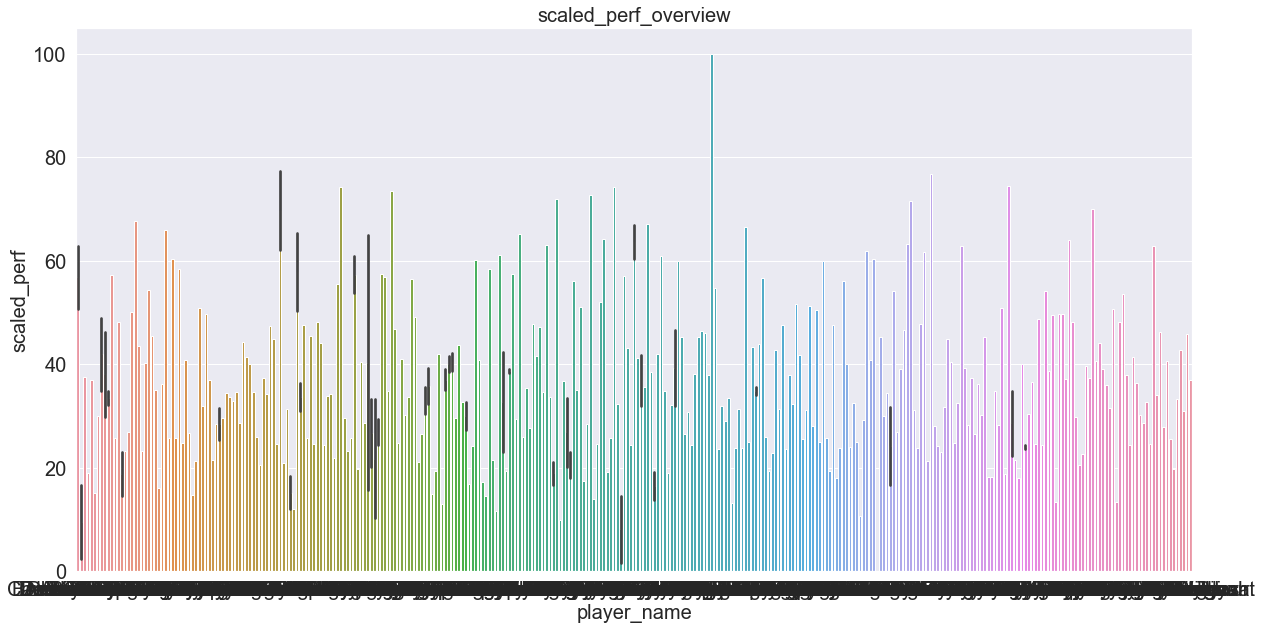

In [59]:
_, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="player_name", y="scaled_perf", data=df_performance_eval, ax=ax)
# plt.bar(df_performance_eval['player_name'], df_performance_eval['scaled_perf'])
plt.xlabel('player_name')
plt.ylabel("scaled_perf")
plt.title("scaled_perf_overview")
plt.show();

In [60]:
df_performance_eval_std = df_performance_eval.sort_values(df_performance_eval.columns[2])

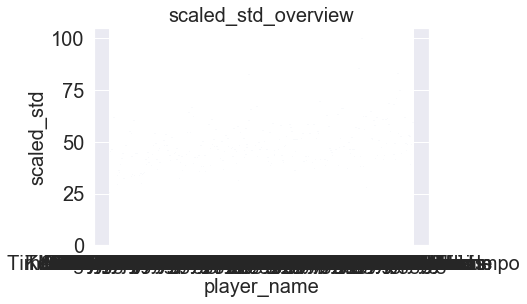

In [61]:
plt.figure()
plt.bar(df_performance_eval_std['player_name'], df_performance_eval_std['scaled_std'])
plt.xlabel('player_name')
plt.ylabel("scaled_std")
plt.title("scaled_std_overview")
plt.show();

In [62]:
df_performance_eval

,own_team_name,player_name,avg_performance_score,avg_performance_deviation,scaled_perf,scaled_std
0,Atlanta Hawks,Alex Len,41.689893,19.934228,50.74,74.01
1,Atlanta Hawks,Allen Crabbe,21.933182,12.918346,16.71,46.37
2,Atlanta Hawks,Bruno Fernando,34.023709,16.033994,37.53,58.64
3,Atlanta Hawks,Cameron Reddish,23.258536,10.015652,18.99,34.93
4,Atlanta Hawks,Damian Jones,33.657102,11.391554,36.90,40.35
...,...,...,...,...,...,...
364,Washington Wizards,Moritz Wagner,37.100327,17.277462,42.83,63.54
365,Washington Wizards,Rui Hachimura,30.241025,12.729766,31.02,45.62
366,Washington Wizards,Shabazz Napier,31.981176,12.107469,34.01,43.17
367,Washington Wizards,Thomas Bryant,38.814947,13.009664,45.78,46.73


## By position

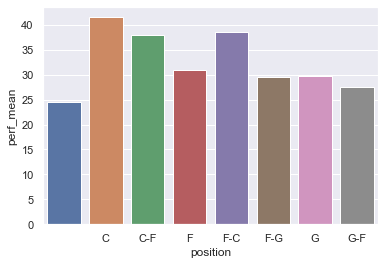

In [137]:
by_pos = df.groupby("player_position").agg({"performance_score": ["nunique", "mean", "std"]})
by_pos.reset_index(inplace=True)
by_pos.columns = ["position", "perf_nunique", "perf_mean", "perf_std"]

sns.barplot(data=by_pos, x="position", y="perf_mean")

In [151]:
def compare_stat_by_position(stat_name: str, take_only_primary_pos: bool = False) -> None:    
    by_pos = df.groupby("player_position", as_index=False).agg({stat_name: "mean"})
    if take_only_primary_pos:
        by_pos["player_position"] = by_pos["player_position"].apply(lambda s: s.split("-")[0] if s else "None")
    by_pos.reset_index(inplace=True)
    by_pos.columns = ["idx", "position", "stat_mean"]

    sns.barplot(data=by_pos, x="position", y="stat_mean")

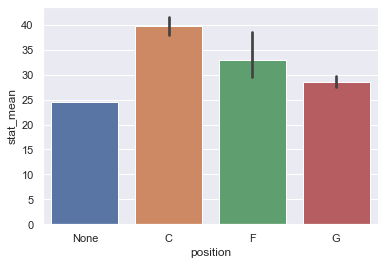

In [153]:
compare_stat_by_position(stat_name="performance_score", take_only_primary_pos=True)

# Aggregate for teams

<i>Per game > per team: aggregate performance scores (mean, std, win, home / away)<i>

In [77]:
[x for x in df.columns]

['assists',
 'blocks',
 'defensive_rebounds',
 'three_pt_percentage',
 'three_pt_attempts',
 'three_pt_made',
 'two_pt_percentage',
 'two_pt_attempts',
 'two_pt_made',
 'one_pt_percentage',
 'one_pt_attempts',
 'one_pt_made',
 'game_object',
 'min',
 'offensive_rebounds',
 'personal_fouls',
 'points',
 'rebounds',
 'steals',
 'turnovers',
 'own_team_id',
 'own_team_name',
 'player_id',
 'player_position',
 'player_name',
 'game_id',
 'mins_played',
 'secs_played',
 'performance_score',
 'game_winning_team',
 'own_team_won',
 'team_points_share']

In [126]:
per_game_performances = df.groupby(["game_id", "own_team_name", "own_team_won", "is_home_game"])\
                .agg({"performance_score": ["mean", "std", "min", "max"]})
per_game_performances.reset_index(inplace=True)
per_game_performances.columns = [
    "game_id", "own_team_name", "team_did_win", "is_home_game", "performance_score_mean",
    "performance_score_std", "performance_score_min", "performance_score_max"
]
per_game_performances.sort_values(by="game_id", ascending=True)

per_game_performances

,game_id,own_team_name,team_did_win,is_home_game,performance_score_mean,performance_score_std,performance_score_min,performance_score_max
0,62585,LA Clippers,True,True,34.324228,11.360212,16.492578,49.366898
1,62585,Los Angeles Lakers,False,False,26.417048,19.327725,6.571262,58.046145
2,62586,Charlotte Hornets,True,True,29.232698,12.426307,12.616202,49.431902
3,62586,Chicago Bulls,False,False,34.717028,15.000385,11.205179,62.983361
4,62588,Cleveland Cavaliers,False,False,34.585902,15.225576,17.252711,59.457302
...,...,...,...,...,...,...,...,...
1883,63553,Miami Heat,False,True,35.306481,17.416891,11.027095,51.328502
1884,63554,Detroit Pistons,False,False,30.092426,14.309457,9.387352,52.345538
1885,63554,Philadelphia 76ers,True,True,36.669044,17.891642,14.266304,69.816054
1886,63556,Dallas Mavericks,True,True,36.089701,23.899457,17.857143,77.956989


In [110]:
heat_stats = per_game_performances.loc[per_game_performances.own_team_name == "Miami Heat"]

heat_stats.tail(10)

,game_id,own_team_name,team_did_win,performance_score_mean,performance_score_std,performance_score_min,performance_score_max
1613,63418,Miami Heat,True,38.052819,16.280278,7.278020,54.585153
1641,63432,Miami Heat,False,34.164049,13.326675,10.522818,55.071721
1678,63451,Miami Heat,False,33.360942,16.882745,11.351909,69.852941
1703,63463,Miami Heat,True,34.081164,14.914562,20.491803,70.013661
1719,63471,Miami Heat,True,34.724583,10.867209,21.025392,52.879367
1754,63489,Miami Heat,True,37.591627,12.667658,14.058107,53.820497
1780,63502,Miami Heat,True,36.248664,13.533652,19.352918,63.455240
1814,63519,Miami Heat,False,34.709788,23.014217,0.001000,66.686137
1844,63534,Miami Heat,True,33.867791,18.243942,10.442774,66.939234
1883,63553,Miami Heat,False,35.306481,17.416891,11.027095,51.328502
